**• Input**: File tài liệu cần hỏi đáp và một câu hỏi liên quan đến nội dung tài liệu.

**• Output**: Câu trả lời.

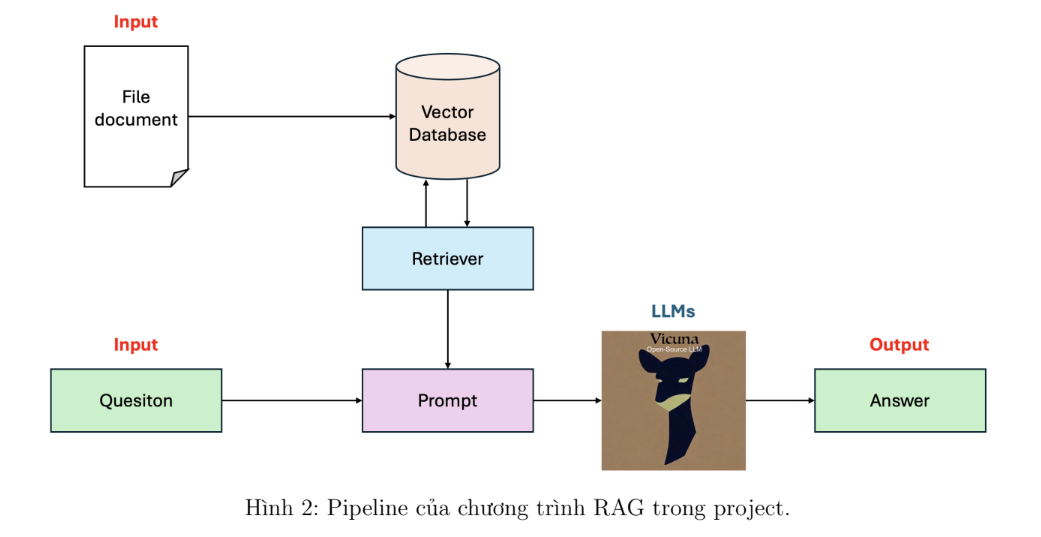

In [1]:
!pip install -q transformers==4.41.2
!pip install -q bitsandbytes==0.43.1
!pip install -q accelerate==0.31.0
!pip install -q langchain==0.2.5
!pip install -q langchainhub==0.1.20
!pip install -q langchain-chroma==0.1.1
!pip install -q langchain-community==0.2.5
!pip install -q langchain_huggingface==0.0.3
!pip install -q python-dotenv==1.0.1
!pip install -q pypdf==4.2.0
!pip install -q numpy==1.24.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [2]:
import torch

from transformers import BitsAndBytesConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface.llms import HuggingFacePipeline

from langchain.memory import ConversationBufferMemory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.chains import ConversationalRetrievalChain

from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

In [4]:
# https://drive.google.com/file/d/1lWuq0COKnU9mCfMvTEq54DBLgAh3yYDx/view?usp=drive_link
!gdown 1lWuq0COKnU9mCfMvTEq54DBLgAh3yYDx

Downloading...
From: https://drive.google.com/uc?id=1lWuq0COKnU9mCfMvTEq54DBLgAh3yYDx
To: /content/YOLOv10_Tutorials.pdf
100% 16.6M/16.6M [00:00<00:00, 63.5MB/s]


In [5]:
# Read pdf file
Loader = PyPDFLoader
FILE_PATH = "./YOLOv10_Tutorials.pdf"
loader = Loader(FILE_PATH)
documents = loader.load()

In [6]:
#Initialize text splitter and split document
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,
                                               chunk_overlap=100)

In [7]:
docs = text_splitter.split_documents(documents)

print("Number of mini-documents: ", len(docs))
docs[0]

Number of mini-documents:  33


Document(metadata={'source': './YOLOv10_Tutorials.pdf', 'page': 0}, page_content='AI VIET NAM – AI COURSE 2024\nTutorial: Phát hiện đối tượng trong ảnh với\nYOLOv10\nDinh-Thang Duong, Nguyen-Thuan Duong, Minh-Duc Bui và\nQuang-Vinh Dinh\nNgày 20 tháng 6 năm 2024\nI. Giới thiệu\nObject Detection (Tạm dịch: Phát hiện đối tượng) là một bài toán cổ điển thuộc lĩnh vực\nComputer Vision. Mục tiêu của bài toán này là tự động xác định vị trí của các đối tượng trong\nmột tấm ảnh. Tính tới thời điểm hiện tại, đã có rất nhiều phương pháp được phát triển nhằm\ngiải quyết hiệu quả bài toán này. Trong đó, các phương pháp thuộc họ YOLO (You Only Look\nOnce) thu hút được sự chú ý rất lớn từ cộng đồng nghiên cứu bởi độ chính xác và tốc độ thực\nthi mà loại mô hình này mang lại.\nHình 1: Logo của mô hình YOLO. Ảnh: link.\nThời gian vừa qua, Ao Wang và các cộng sự tại Đại học Thanh Hoa (Tsinghua University)\nđã đề xuất mô hình YOLOv10 trong bài báo YOLOv10: Real-Time End-to-End Object\nDetection [10]. Vớ

In [8]:
# Khởi tạo instance vectorization: Embed các đoạn văn bản thành vector để dễ dàng tính toán và so sánh hơn.
embedding = HuggingFaceEmbeddings()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
#Khởi tạo Vector Database: Đưa các thông tin từ kết quả text_splitter và embedding vào hàm dùng để khởi tạo Vector Database.
vector_db = Chroma.from_documents(documents=docs,
                                  embedding=embedding)

retriever = vector_db.as_retriever()

In [10]:
test_result = retriever.invoke("What is YOLO?")

print("Number of relevant documents:", len(test_result))

Number of relevant documents: 4


In [12]:
# Khởi tạo mô hình ngôn ngữ lớn: Sử dụng mô hình Vicuna
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

MODEL_NAME = "lmsys/vicuna-7b-v1.5"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=nf4_config,
    low_cpu_mem_usage=True
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id,
    device_map="auto"
)

llm = HuggingFacePipeline(
    pipeline=model_pipeline,
)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [13]:
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

USER_QUESTION = "YOLOv10 là gì?"
output = rag_chain.invoke(USER_QUESTION)
output

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


'Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don\'t know the answer, just say that you don\'t know. Use three sentences maximum and keep the answer concise.\nQuestion: YOLOv10 là gì? \nContext: 2.Tải trọng số của pre-trained models: Để sử dụng được pre-trained models, chúng ta\ncần tải về file trọng số (file .pt). Các bạn chạy đoạn code sau để tải về file trọng số phiên\nbản YOLOv10n:\n1! wget https :// github .com/THU -MIG/ yolov10 / releases / download /v1 .1/\nyolov10n .pt\n3.Khởi tạo mô hình: Để khởi tạo mô hình với trọng số vừa tải về, các bạn chạy đoạn code\nsau:\n1from ultralytics import YOLOv10\n2\n3model = YOLOv10 (" yolov10n .pt")\n4.Tải ảnh cần dự đoán: Chúng ta sẽ test mô hình trên một ảnh bất kì. Các bạn có thể tự\nchọn ảnh của riêng mình hoặc sử dụng ảnh tại đây. Các bạn có thể chạy đoạn code sau để\ntải ảnh này vào colab tự động:\n1! gdown "1 tr9PSRRdlC2pNir7jsYugpSMG -7 v32VJ " -O

In [14]:
answer = output.split("Answer:")[1].strip()
print(answer)

YOLOv10 là một phiên bản của YOLO (You Only Look Once) - một hệ thống dự đoán hình ảnh được huấn luyện sẵn trên bộ dữ liệu COCO. Phiên bản này được tạo bằng cách tải về trọng số (file.pt) từ GitHub và khởi tạo mô hình bằng cách sử dụng thư viện ultralytics.
